In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

runs = pd.read_csv("data/cleaned/runs_with_weights.csv")
runs.head()

# runs[['weight', 'Avg Pace (min/km)', 'Distance (km)']].describe()



,date,Calories Burned (kCal),Distance (km),Workout Time (seconds),Avg Pace (min/km),Max Pace (min/km),Avg Speed (km/h),Steps,Notes,Link,weight
0,2016-10-27,349,3.869056,1691,7.284272,3.416317,8.236896,4442.0,NaN,http://www.mapmyfitness.com/workout/1837545095,79.381141
1,2016-11-24,522,5.811148,1711,4.907229,0.927738,12.226846,4690.0,NaN,http://www.mapmyfitness.com/workout/1882757897,79.270206
2,2019-03-28,329,3.790617,1702,7.483422,3.388921,8.017736,4460.0,NaN,http://www.mapmyfitness.com/workout/3451593310,75.886688
3,2019-04-05,302,3.684126,1672,7.564014,1.193051,7.932312,4378.0,NaN,http://www.mapmyfitness.com/workout/3466849531,75.854992
4,2019-09-19,310,3.532092,1557,7.346907,4.672730,8.166681,4087.0,OK not hot,http://www.mapmyfitness.com/workout/3800745034,75.193344


<Axes: xlabel='weight', ylabel='Avg Pace (min/km)'>

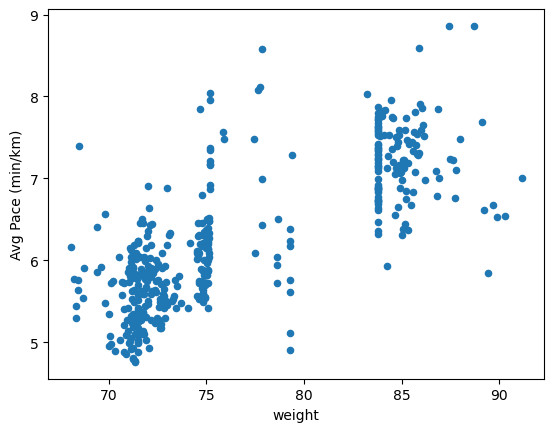

In [2]:
# scatterplot of weight vs avg pace
runs.plot.scatter(x='weight', y='Avg Pace (min/km)')


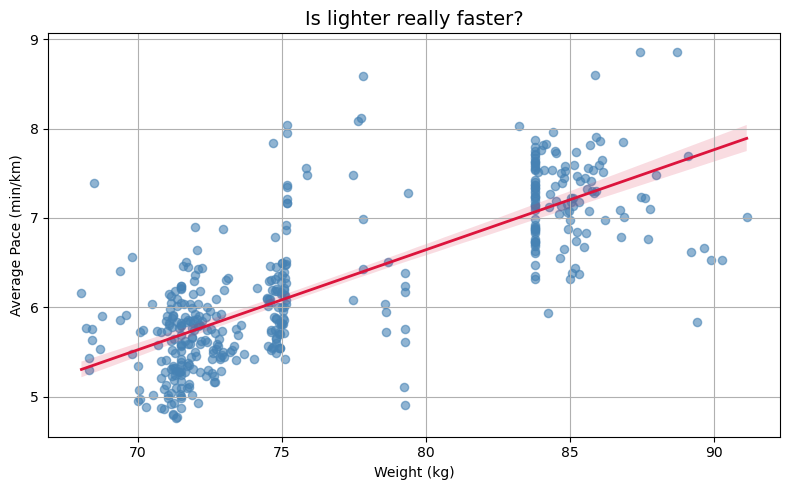

Pearson r: 0.7694795694250541


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.regplot(
    data=runs,
    x='weight',
    y='Avg Pace (min/km)',
    scatter_kws={'color': 'steelblue', 'alpha': 0.6, 's': 35},
    line_kws={'color': 'crimson', 'linewidth': 2}
)
plt.title('Is lighter really faster?', fontsize=14)
plt.xlabel('Weight (kg)')
plt.ylabel('Average Pace (min/km)')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Pearson r:", runs['weight'].corr(runs['Avg Pace (min/km)']))



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(runs["weight"], runs["Avg Pace (min/km)"])

# Regression line
y_pred = intercept + slope * runs["weight"]

# Print equation
print(f"y = {intercept:.2f} + {slope:.2f}x")

print(f"b_1 = {r_value}({runs['Avg Pace (min/km)'].std()}/{runs['weight'].std()})")


y = -2.31 + 0.11x
b_1 = 0.769479569425054(0.8670067491467701/5.959948718672327)


The formula for a linnear regression

$$
b_1 = r \frac{s_y}{s_x}
$$

With my numbers:
$$
b_1 = 0.77 (\frac{0.87}{5.96}) 
$$


In [ ]:
# Number of runs per week
run_counts_weekly = runs.resample('W').size().rename('runs_per_week')

# Combine with average weekly pace and weight
weekly_stats = runs.resample('W').agg({
    'Distance (km)': 'sum',
    'Avg Pace (min/km)': 'mean',
    'weight': 'mean'
})

# Merge frequency in
weekly_stats = weekly_stats.join(run_counts_weekly)
print(weekly_stats)


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [ ]:
print(weekly_stats[['runs_per_week', 'Avg Pace (min/km)', 'weight']].corr())

                   runs_per_week  Avg Pace (min/km)    weight
runs_per_week           1.000000          -0.054789  0.060901
Avg Pace (min/km)      -0.054789           1.000000  0.729902
weight                  0.060901           0.729902  1.000000


Text(0.5, 1.0, 'Does running more often = faster pace?')

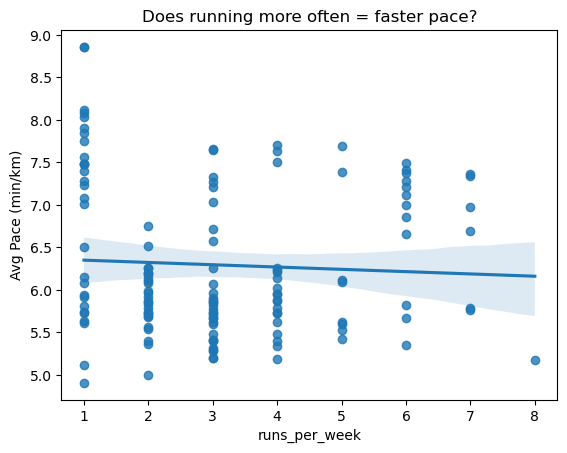

In [ ]:
sns.regplot(data=weekly_stats, x='runs_per_week', y='Avg Pace (min/km)')
plt.title("Does running more often = faster pace?")


Text(0.5, 1.0, 'Does running more often = faster pace?')

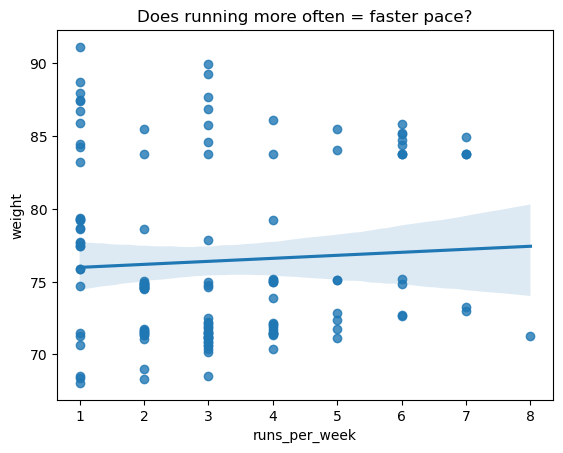

In [ ]:
sns.regplot(data=weekly_stats, x='runs_per_week', y='weight')
plt.title("Does running more often = faster pace?")

In [ ]:
# 1. Ensure date is datetime
runs['date'] = pd.to_datetime(runs['date'], errors='coerce')

# 2. Set as index for rolling + resampling
runs = runs.sort_values('date').set_index('date')  # must be DatetimeIndex

runs['roll7_weight'] = runs['weight'].rolling(7).mean()
runs['roll7_pace']   = runs['Avg Pace (min/km)'].rolling(7).mean()
runs['weekly_km']    = runs['Distance (km)'].resample('W').sum()


In [ ]:
print(runs.index)
print(type(runs.index))

DatetimeIndex(['2016-10-27', '2016-11-24', '2019-03-28', '2019-04-05',
               '2019-09-19', '2019-09-20', '2019-09-21', '2019-09-22',
               '2019-09-23', '2019-09-24',
               ...
               '2025-06-22', '2025-06-24', '2025-06-25', '2025-06-26',
               '2025-06-27', '2025-06-28', '2025-06-29', '2025-07-01',
               '2025-07-02', '2025-07-03'],
              dtype='datetime64[ns]', name='date', length=424, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


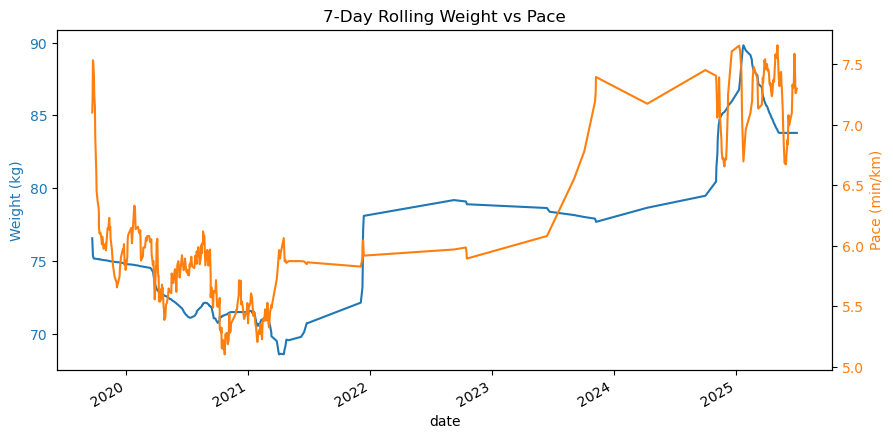

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_ylabel('Weight (kg)', color='tab:blue')
runs['roll7_weight'].plot(ax=ax1, color='tab:blue', label='7-day Weight')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Pace (min/km)', color='tab:orange')
runs['roll7_pace'].plot(ax=ax2, color='tab:orange', label='7-day Pace')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('7-Day Rolling Weight vs Pace')
plt.show()
